# Probabilistic models and Bayesian decision making: How much Hay?

At DataJavelin, we specialise in building bespoke probabilistic models for our clients and we often do this using Bayesian probability. 

Bayesians think about probability as a measure of plausibility i.e. how likely is to rain, given certain assumptions? This compares to the typical frequentist way of thinking about probability who define it as a frequency of events i.e. it has rained 3 out of 7 days. By using Bayesian methods to fit probabilistic models, we have the advantage of not just getting the “best fit” parameter values in our model, but also the uncertainty associated with that fit i.e. how plausible is that association. Taking the uncertainty into account is important when making informed, optimal decisions.

We recently carried out consultancy work alongside [Prof. Seb Oliver](http://www.sussex.ac.uk/profiles/91548), [Dr Raphael Shirley](http://raphaelshirley.co.uk/), [Dr Steve Duivenvoorden](https://www.linkedin.com/in/steven-duivenvoorden-813b8714a) from the University of Sussex and [Dr Edward Pope](https://www.metoffice.gov.uk/research/people/edward-pope) from the Met Office on the [Science and Technology Funding Council's Food plus network project](https://www.stfcfoodnetwork.org/), [FACYnation](https://www.stfcfoodnetwork.org/awarded-projects.html). The project's aims were to build an empirical, data-driven model of crop yield as a function of temperature and precipitation to help forecast the possible impact of changes in climate. It has led to a soon to be published paper (Shirley et al. 2019).

We were brought on the project to build the prototype data driven model, that takes in historic monthly temperature and precipitation data and corresponding yields for different regions and crops, and outputs a model that can predict future yields.

While the FACYnation project was very much research focused, in this blog post we show how the same model can be used to make more informed decisions in the commercial world using Bayesian decision theory. In particular, we will demonstrate how using Bayesian methods which account for uncertianty, leads to better and commercial decisions (i.e. more money)!

There have been some excellent blog posts on Bayesian decision theory. In particular, I would recommend [Justin Silverman's](http://www.statsathome.com/2017/10/12/bayesian-decision-theory-made-ridiculously-simple/) and [Thomas Wiecki's](https://twiecki.io/blog/2019/01/14/supply_chain/) posts for other examples.


## Our example agricultural problem: How much Hay to grow?
A farmer in East Sussex has a mixed farm, i.e. both arable and pastoral. They have 100 cows and 100 hectares of field. During the winter months the cattle are brought from the fields and housed indoors, the cattle usually come inside in November and will remain inside until spring. When indoors, the cattle tend to be fed hay.

Being a mixed farm, the Farmer has a couple of choices. They can use some of the fields to grow, cut and store the hay the cattle will need, or it can be bought from a supplier. Buying tends to be more expensive, so they prefer to grow hay on the farm. But:

* If they grow to much, they have to sell the remainder. In today's farming market it costs more to grow then they get back selling and so the farmer will lose money.

* If they grow too little, the farmer has to buy more hay in and has to spend more money.

What is the optimum amount of land the farmer should use to grow hay for their cattle to minimise the amount of money they have to spend?

We can use the crop yield model we built for the FACYnation project to help answer this question. In the following blog post we will:

* [Briefly introduce the crop yield model](#the-crop-yield-model) 
* [Get historical weather data for East Sussex](#the-weather-data)
* [Use the model to predict hay yields ](#prediciting-hay-yields)
* [Use Bayesian Decision theory to decide the optimum amount of land the farmer should use to grow hay](#using-bayesian-decision-theory)
* [Compare to traditional method which ignores uncertianty](#the-cost-of-ignoring-uncertianty)

## The Crop yield model

The FACYnation crop yield model assumes the monthly growth of a crop is related to temperature and precipitation and that the growth can modelled as a 2D Gaussian. The final crop yield, Y, is found by summing up the growth in each month, i, using the monthly temperature and precipitation measurements x<sub>i</sub>.  

$$
{\boldsymbol Y}(T,P) =\sum_i N \frac{\exp\left(-\frac{1}{2} ({\mathbf x_i}-{\boldsymbol \mu})^\intercal {\boldsymbol \Sigma}^{-1}  ({\mathbf x_i}-{\boldsymbol \mu})\right)}{\sqrt{(2\pi)^k | \boldsymbol \Sigma|}}
$$


The aim of the FACYnation project was to learn the parameters of the 2D Gaussain representation of the growth function (e.g. mean, covariance and normalisation constant) from historical weather and yield data.

In this project, we assume we have learnt the parameters of the hay growth model, and will use it to predict crop yields based on monthly temperature and precipitation. 

We will use the probabilisitic programming language, [Stan](https://mc-stan.org/), to build and carry out inference on the probabilistic model. 



In [3]:
import pystan
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline
import seaborn as sns


## The Weather data
Our crop yield model needs temperature and precipitation data. The Met Office holds archival data for Eastbourne which you can get [here](https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/eastbournedata.txt). 

Lets take a look at that data

In [4]:
weath=pd.read_csv('eastbourne.txt',header=5,delim_whitespace=1)
weath=weath.drop(weath.index[0])
weath=weath.drop(weath.index[-1])
weath = weath.apply(pd.to_numeric)
weath.head(5)

,yyyy,mm,tmax,tmin,af,rain,sun
1,1959,1,6.4,1.1,13,109.5,100.4
2,1959,2,6.6,2.0,4,0.0,73.4
3,1959,3,10.4,5.1,0,43.0,128.4
4,1959,4,12.7,7.3,0,62.5,163.5
5,1959,5,16.8,9.3,0,12.5,250.1


The data consists of Mean daily maximum temperature (tmax), Mean daily minimum temperature (tmin), Days of air frost (af), Total rainfall (rain) and Total sunshine duration (sun). According to the Met office website, the monthly mean temperature is calculated from the average of the mean daily maximum and mean daily minimum temperature i.e. (tmax+tmin)/2. Lets add this column

In [5]:
weath['tmean'] = weath.apply(lambda row: (row.tmax + row.tmin)/2, axis=1)
weath.head(5)

,yyyy,mm,tmax,tmin,af,rain,sun,tmean
1,1959,1,6.4,1.1,13,109.5,100.4,3.75
2,1959,2,6.6,2.0,4,0.0,73.4,4.30
3,1959,3,10.4,5.1,0,43.0,128.4,7.75
4,1959,4,12.7,7.3,0,62.5,163.5,10.00
5,1959,5,16.8,9.3,0,12.5,250.1,13.05


## Prediciting Hay Yields
Now we have monthly mean temperature and precipitation, we can feed this into the model. First, lets see how much the mean temperature and total precipitation for each month varies between years.

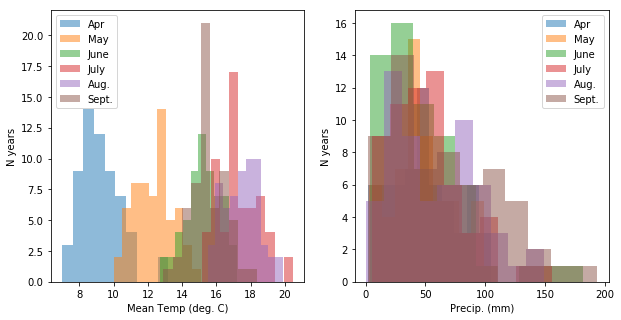

In [6]:
plt.figure(figsize=(10,5))
month=['Apr','May','June','July','Aug.','Sept.']
plt.subplot(1,2,1)
for i,s in enumerate(weath.pivot(index='yyyy',columns='mm',values='tmean').iloc[:,3:9].values.T):
    plt.hist(s, alpha=0.5,label=month[i])
plt.xlabel('Mean Temp (deg. C)')
plt.ylabel('N years')
plt.legend()
plt.subplot(1,2,2)
for i,s in enumerate(weath.pivot(index='yyyy',columns='mm',values='rain').iloc[:,3:9].values.T):
    plt.hist(s, alpha=0.5,label=month[i])
plt.xlabel('Precip. (mm)')
plt.ylabel('N years')
plt.legend()

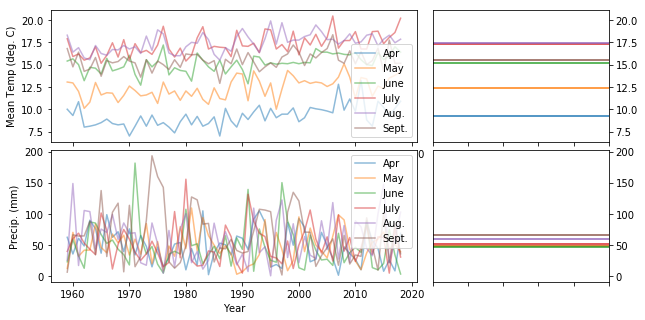

In [7]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(6, 6, hspace=0.2, wspace=0.2)# row, column
temp_ax = fig.add_subplot(grid[0:3, 0:-2])
precip_ax = fig.add_subplot(grid[3:, 0:-2])
temp_hist = fig.add_subplot(grid[0:3,-2:], xticklabels=[], sharey=temp_ax)
precip_hist = fig.add_subplot(grid[3:,-2:], xticklabels=[], sharey=precip_ax)


month=['Apr','May','June','July','Aug.','Sept.']
for i,s in enumerate(weath.pivot(index='yyyy',columns='mm',values='tmean').iloc[:,3:9].values.T):
    temp_ax.plot(weath.pivot(index='yyyy',columns='mm',values='tmean').iloc[:,3:9].index,s, alpha=0.5,label=month[i])
    #temp_hist.hist(s, alpha=0.5, histtype='stepfilled',orientation='horizontal')
    temp_hist.axhline(np.mean(s),c=temp_ax.get_lines()[-1].get_color())
    
temp_ax.set_ylabel('Mean Temp (deg. C)')
temp_ax.set_xlabel('Year')
temp_ax.legend()

for i,s in enumerate(weath.pivot(index='yyyy',columns='mm',values='rain').iloc[:,3:9].values.T):
    precip_ax.plot(weath.pivot(index='yyyy',columns='mm',values='tmean').iloc[:,3:9].index,s, alpha=0.5,label=month[i])
    #precip_hist.hist(s, alpha=0.5, histtype='stepfilled',orientation='horizontal')
    precip_hist.axhline(np.mean(s),c=precip_ax.get_lines()[-1].get_color())

    
precip_ax.set_ylabel('Precip. (mm)')
precip_ax.set_xlabel('Year')
precip_ax.legend()
precip_hist.yaxis.set_ticks_position('right')
temp_hist.yaxis.set_ticks_position('right')




In [8]:
weath.pivot(index='yyyy',columns='mm',values='tmean').iloc[:,3:9].index

Int64Index([1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
            1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
            1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
            1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
            2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
            2014, 2015, 2016, 2017, 2018],
           dtype='int64', name='yyyy')

As can be seen in the plot above, not only do the temperature and precipitation differ for different months but there is also quite a between years for the same month. The variation in temperature and precipitation has a big effect on the growth of hay and so we should be taking it into account in our model. We will therefore use the mean and standard deviation for temperature and precipitation for each month and model the variation with a Normal distribution.

Later on in this blog post, we will illustrate what happens to the decision if you ignore this variation and just use the mean temperature and precipitation for each month. 

Now lets compile the FACYnation model, written in Stan and use it to predict the range of possible yields we would could get, taking into account the variation in temperature and precipitation.

In [9]:
sm=pystan.StanModel(file='./FACYnation_crop_yield.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a53ee2cc87ddc8008b1968b4560ec60b NOW.
/Users/pdh21/anaconda3/envs/mindlab/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/nz/r72y6t5s5t3bbjl26n528zvr000gh2/T/tmplcy8_98n/stanfit4anon_model_a53ee2cc87ddc8008b1968b4560ec60b_7865860843296260135.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [10]:
data={
    'n_regions':1,
    'n_years':1,
    'd_temp_mu':np.mean(weath.pivot(index='yyyy',columns='mm',values='tmean').iloc[:,3:9].values,axis=0)[None,None,:],
    'd_temp_sig':np.std(weath.pivot(index='yyyy',columns='mm',values='tmean').iloc[:,3:9].values,axis=0)[None,None,:],
    'd_precip_mu':np.mean(weath.pivot(index='yyyy',columns='mm',values='rain').iloc[:,3:9].values,axis=0)[None,None,:],
    'd_precip_sig':np.mean(weath.pivot(index='yyyy',columns='mm',values='rain').iloc[:,3:9].values,axis=0)[None,None,:],
    'd_yields':np.array([0])[None,:],#not required since we are prediciting yield not fitting to it
    'n_gf':40,
    'temp':np.arange(0,40,1),
    'precip':np.arange(0,200,5)
}

In [11]:
fit=sm.sampling(data=data,iter=1000,chains=4)

In [12]:
crop_yield_post_pred=pd.DataFrame(fit['pred_yields'].flatten())

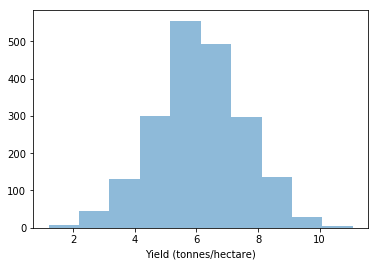

In [13]:
plt.hist(crop_yield_post_pred,alpha=0.5)
plt.xlabel('Yield (tonnes/hectare)')

The plot above shows the posterior probability distribution for yield. It shows the probability of getting a particular yield of hay, given the variable weather in Eastbourne. The width of the distribution is driven by uncertianty in model parameters and more importantly, the variation in temperature and precipitation across years.

## Using Bayesian Decision Theory

Now we have our predicitions for crop yield, we need to come up with a loss function. This function should define the cost of what happens if the farmer does not grow enough hay and the cost of growing too much. First, lets define some useful number which will be needed to make the decision:

* GROWTH_PRICE: How much money, per hecatare, that it costs to grow hay e.g. seed cost, tractor fuel, harvesting etc
* SALES_PRICE: How much money the farmer will make for surplus hay, per tonne
* BUY_PRICE: How much it costs to buy hay 
* FEED: How much total feed is required for the herd
* MAX_FIELD_SIZE: The maximum area the farmer has for growing hay

In [14]:
GROWTH_PRICE=250*2.471 #How much it costcost per hectare
SALES_PRICE=60.0
BUY_PRICE=110.0 #£ per tonne
FEED=1*100.0 #tonnes times number of cows e.g. https://www.daera-ni.gov.uk/articles/silage-management
MAX_FIELD_SIZE=200.0 #57 hectares

Now lets define the loss function. 

In [15]:
@np.vectorize
def loss_feed_simple(crop_yield, field_size,growth_price=GROWTH_PRICE,sales_price=SALES_PRICE,
                     feed=FEED,buy_price=BUY_PRICE):
    # How much do we earn per tonne
    margin = sales_price - growth_price/crop_yield
    # How much will we have
    stock=crop_yield*field_size
    #if stock is less than feed
    if stock <feed:
        reward = -(feed-stock)*buy_price
    #if stock is more than feed
    if stock >feed:
        reward=(stock-feed)*margin
    # as we want to minimise we will multiply by -1
    return -reward

Our loss function is fairly simple. For a given crop yield and field size, it works out how much money is lost. There are two possibilities. If the amount of hay is less than the feed needed then additional hay needs to be bought and that will eat into profit. The alternative is that more hay is grown than is needed by the cows and the additional hay will need to be sold (but at a loss since it costs more to grow than you get in profit).

Lets see how the loss function behaves as a function of field size if we fix crop yield to 6 tonnes per hectare.

(0, 12000)

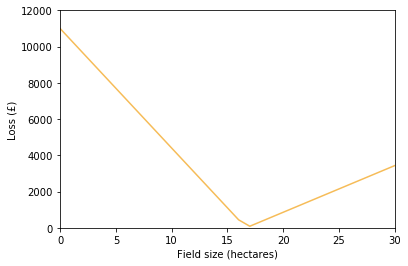

In [16]:
plt.plot(np.arange(0,31),loss_feed_simple(6,np.arange(0,31)),c='#f6bc58')
plt.ylabel('Loss (£)',)
plt.xlabel('Field size (hectares)')
plt.xlim(0,30)
plt.ylim(0,12000)

You can see in the plot above, that for a crop yield of 6 tonnes per hectare, to minimse loss, the farmer should plant around 16 hectares of hay. However, we know from our posterior distribution on crop yield, that there are a range of possible values. The posterior distribution also gives us the probability of obtaining a particular crop yield.

The objective function takes the posterior probability distribution on yields from our model and applies it to the loss function. It does this as a function of `fields` i.e. the field size which we are trying to optimise like in our example above. However, unlike before, it will return the distribution of losses, for a given field size.

In [17]:
def objective(fields, crop_yield=crop_yield_post_pred, max_field_size=MAX_FIELD_SIZE):
    losses = []
    
    # Negative orders are impossible, indicated by np.inf
    if np.any(fields < 0):
        return np.inf
    # Ordering more than the supplier can ship is also impossible
    if np.any(fields > max_field_size):
        return np.inf
    
    # Iterate over post pred samples provided in supplier_yield
    for i, crop_yield_sample in crop_yield.iterrows():
        # evaluate loss over each sample with one sample from the demand distribution
        loss_i=loss_feed_simple(crop_yield_sample, fields,growth_price=GROWTH_PRICE,sales_price=SALES_PRICE,
                     feed=FEED,buy_price=BUY_PRICE)
        losses.append(loss_i)
    return np.asarray(losses)

We are now ready to optimise the objective function. We will use the scipy optimize function to this. It will give different field sizes to the objecive function to try and find the field size which gives the minimum, mean loss.

In [18]:
from scipy import optimize

In [19]:
# parameters for the optimization, we're just including the max field size as bounds
bounds = [(0.0, MAX_FIELD_SIZE)]
starting_value =30.0

In [50]:
# minimize the expected loss under all possible scenarios
opt_prob = optimize.minimize_scalar(lambda *args: np.mean(objective(*args)),  
                              bounds=bounds)

In [26]:
print('Optimal field size = {:6.1f} hectares'.format(opt_prob.x))

Optimal field size =   18.6 hectares


The optimum field size for growing hay for feed is 18.6 hectares. Lets see how it made the decision by looking at the objective function as a function of field size.

(0, 12000)

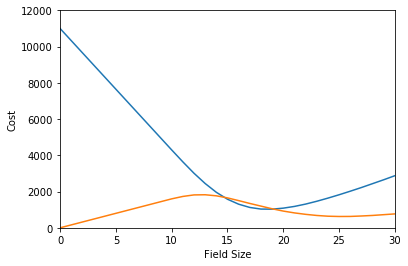

In [28]:
tmp=[]
for i in range(0,int(MAX_FIELD_SIZE)):
    tmp.append([np.mean(objective(i, crop_yield=crop_yield_post_pred, max_field_size=MAX_FIELD_SIZE)),np.std(objective(i, crop_yield=crop_yield_post_pred, max_field_size=MAX_FIELD_SIZE))])

plt.plot(np.arange(0,MAX_FIELD_SIZE),tmp)
#plt.plot(np.arange(0,31),loss_feed_simple(7.13,np.arange(0,31)),c='#f6bc58')
plt.ylabel('Cost')
plt.xlabel('Field Size')
plt.xlim(0,30)
plt.ylim(0,12000)

In [30]:
tmp=np.array(tmp)

(-2000, 12000)

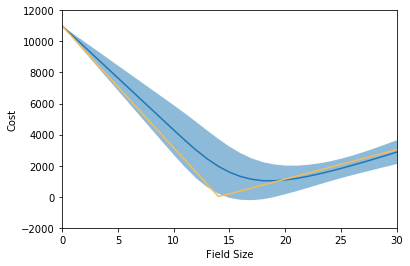

In [36]:
plt.plot(np.arange(0,MAX_FIELD_SIZE),tmp[:,0])
plt.plot(np.arange(0,31),loss_feed_simple(7.13,np.arange(0,31)),c='#f6bc58')
plt.fill_between(np.arange(0,MAX_FIELD_SIZE),tmp[:,0]+tmp[:,1],tmp[:,0]-tmp[:,1],alpha=0.5)
plt.ylabel('Cost')
plt.xlabel('Field Size')
plt.xlim(0,30)
plt.ylim(-2000,12000)

We can see how the optimisation approach has made its decision by searching for the minima. Note how the minimum is curved. Our loss function causes a sharp point minima but the uncertianty in yield prediction has caused the minimum in the objective function to be broadened. 

## The cost of ignoring uncertianty
So far we have demonstrated using a probabilisitic model and Bayesian decision theory to decide how much area the farmer should dedicate to growing hay. But so what?

Lets consider a typical approach to answering the question, where we ignore uncertianty by using the mean  temperature and precipitation, averaged between 1959 and 2017. We can use that average and run it through the FACYnation mathematical model.

In [39]:
def yield_model(temp_6m, precip_6m, mu_t, sigma_t, mu_p, sigma_p, rho, norm):
    """Take six months of T and P and return yield for given params.
        """
    if len(norm) == 1:
        norm = norm * np.ones(6)
    dy = np.zeros(6)
    for month in np.arange(6):
        dy[month] = norm[month]*np.exp(-(1/(2 - 2*rho**2)) *( np.square((temp_6m[month]    - mu_t)/sigma_t) 
                                                           + np.square((precip_6m[month] - mu_p)/sigma_p) 
                                                           - (2*rho*(temp_6m[month]    - mu_t)
                                                                   *(precip_6m[month] - mu_p)
                                                             )
                                                              /(sigma_t*sigma_p)
                                                           )
                                      )
                                      
    return np.sum(dy)

In [40]:
non_prob_crop_yield=pd.DataFrame(np.array([yield_model(np.mean(weath.pivot(index='yyyy',columns='mm',values='tmean').iloc[:,3:9].values,axis=0)
               ,np.mean(weath.pivot(index='yyyy',columns='mm',values='rain').iloc[:,3:9].values,axis=0)
               , 20, 7,100, 74,0,[2.0])]))

In [41]:
print('Crop yield prediction without uncertianty = {:6.2f}'.format(non_prob_crop_yield.values[0][0]))

Crop yield prediction without uncertianty =   7.13


Because we are using one value for temperature and precipitation (the mean), we have one estimate for predicted yield, 7.13. Lets compare this to the posterior probability distribution of predicted yields from our probabilisitic model.

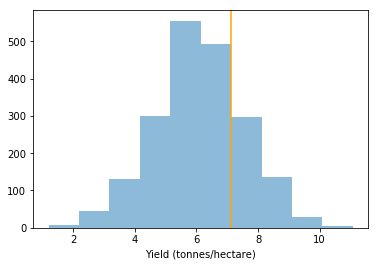

In [42]:
plt.hist(crop_yield_post_pred,alpha=0.5)
plt.axvline(non_prob_crop_yield.values[0][0],c='orange')
plt.xlabel('Yield (tonnes/hectare)')

The predicted yield for the model without uncertianty seem to be quite a bit higher than the average yield from our probabilisitic model with uncertianty.

Let see what the optimum field size would be. We can still use the objective function as before, but now it will be using one value for crop yields rather than the posterior probability distribution.



In [43]:
# minimize the expected loss under all possible scenarios
opt_non_prob = optimize.minimize_scalar(lambda *args: objective(*args,crop_yield=non_prob_crop_yield),  
                              bounds=bounds)

In [44]:
print('Optimal field size = {:6.1f} hectares'.format(opt_non_prob.x.reshape(1)[0]))

Optimal field size =   14.0 hectares


So the model without uncertianty suggests 14.0 hectares, compared to 20.2 hectares. That is quite a big difference. 

But what is the cost of using the two different decisions?

One way we can demonstrate that is by estimating crop yields for past years, using our mathematical model and historical weather data. That way we can compare the cost/benefit of both decisions for each year.

In [45]:
hist_data=[]
for i in zip(weath.pivot(index='yyyy',columns='mm',values='tmean').iloc[:,3:9].values,
             weath.pivot(index='yyyy',columns='mm',values='rain').iloc[:,3:9].values):
    hist_data.append(yield_model(i[0], i[1], 20, 7,100, 74,0,[2.0]))
hist_data=pd.DataFrame(hist_data)

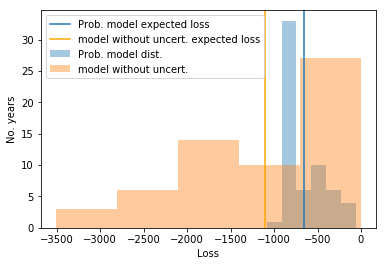

In [51]:
neg_loss_prob = -objective(opt_prob.x, crop_yield=hist_data) 
neg_loss_non_prob = -objective(opt_non_prob.x, crop_yield=hist_data)
sns.distplot(neg_loss_prob, label='Prob. model dist.', kde=False)
plt.axvline(np.mean(neg_loss_prob), label='Prob. model expected loss')
sns.distplot(neg_loss_non_prob, label='model without uncert.', kde=False)
plt.axvline(np.mean(neg_loss_non_prob), color='orange', label='model without uncert. expected loss')
plt.legend(); plt.xlabel('Loss'); plt.ylabel('No. years');

The plot above shows a histrogram of profit (or losses) for between 1959 and 2018. By using the probabilistic model to make the decision (blue line), the farmer loses less on average over the last 60 years than if they were to use the model without uncertianty factored in (orange line).

More importantly, this distribution of loses is wide for the model without uncertianty. There are some years that the farmer will lose less money by opting for the non probabilisitic approach, but the gain will be on the order of £500 in total. On the other hand, there are also a number of years where the farmer would lose a lot more money than expected. By not using uncertianty in the decision making, the farmer is left with more uncertianty in their financial position at the end of the year, as well as less money on average.

As a final comparison, lets look at how the cumulative loss for the two increases from 1959 to 2018 and calculate the difference between the two.

In [52]:
print(np.mean(neg_loss_prob)-np.mean(neg_loss_non_prob))

447.620455595


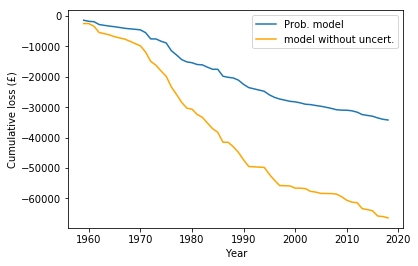

In [47]:
plt.plot(weath['yyyy'].unique(),np.cumsum(neg_loss_prob),label='Prob. model')
plt.plot(weath['yyyy'].unique(),np.cumsum(neg_loss_non_prob),color='orange',label='model without uncert.')
plt.xlabel('Year')
plt.ylabel('Cumulative loss (£)')
plt.legend()

In [48]:
print('Cumulative loss difference between probabilistic and typical approach = £{:6.2f}'.format(np.cumsum(neg_loss_prob)[-1]-np.cumsum(neg_loss_non_prob)[-1]))

Cumulative loss difference between probabilistic and typical approach = £32247.03


The blue line in the plot above shows the cumulative loss if our probabilistic model was used to make the decision on how much hay to grow, compared to the orange line for when the typical approach, (where uncertianty or variation is ignored), is used. 

The cumulative loss from the probabilistic model is significantly less. The cumulative difference between the two approaches is £26170.33. The probabilisitic model is also a lot more steady in how it behaves, as shown by the near straight blue line. The typical approach is less steady as shown by the more sporadic behaviour of the orange line. This behaviour of the lines is due to the same reason the distribution in the histograms are different. Not only does implementing our probabilistic model along with Bayesian decision theory save the farmer money, but it is also easier to financially plan for the future.

## Final Thoughts
When used appropriately, probabilistic modelling and Bayesian decision making can help you make better decisions. The example here is in the agricultural sector, but Bayesian decision making can be applied in numerous areas.

Our model for crop growth was developed for the FACYnation research project. As with all models, there are some assumptions and limitations. For example, we haven't included other important factors in crop growth such as the number of sunlight hours. However, simple models that take into account uncertianty can often outperform an all bells and whistles model that ignores it.  